In [2]:
from Functions import *
from DataDefined import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [44]:
df = pd.read_csv('Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv')

df, label_mappings = preprocessing(df, one_val_col, irrelevant_col, to_be_scaled_col, two_val_col, some_val_num_col, some_val_cat_col)

encoder = LabelEncoder()
df['Class'] = encoder.fit_transform(df['Class'])
print(encoder.classes_, encoder.transform(encoder.classes_))

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J'] [0 1 2 3 4 5 6 7 8 9]


In [45]:
#class_features = ['Class', 'Ride number', 'Time(s)']
#rel_class_features = relevant_features + class_features
#df = df[rel_class_features]
df = add_derivatives(df, delta_col)
df.columns

Index(['Fuel_consumption', 'Accelerator_Pedal_value',
       'Throttle_position_signal', 'Short_Term_Fuel_Trim_Bank1',
       'Intake_air_pressure', 'Absolute_throttle_position',
       'Engine_in_fuel_cut_off', 'Long_Term_Fuel_Trim_Bank1', 'Engine_speed',
       'Torque_of_friction', 'Flywheel_torque_(after_torque_interventions)',
       'Current_spark_timing', 'Engine_coolant_temperature',
       'Engine_Idel_Target_Speed', 'Engine_torque', 'Calculated_LOAD_value',
       'Minimum_indicated_engine_torque', 'Maximum_indicated_engine_torque',
       'Flywheel_torque', 'Standard_Torque_Ratio',
       'Requested_spark_retard_angle_from_TCU',
       'TCU_requests_engine_torque_limit_(ETL)',
       'TCU_requested_engine_RPM_increase',
       'Target_engine_speed_used_in_lock-up_module',
       'Activation_of_Air_compressor', 'Torque_converter_speed',
       'Current_Gear', 'Engine_coolant_temperature.1',
       'Wheel_velocity_front_left-hand', 'Wheel_velocity_rear_right-hand',
       'Whe

In [46]:
X_train, y_train, X_test, y_test, X_val, y_val = splitDataForSVM(df, 1, 3, 42)

### SVM

In [7]:

from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

In [50]:
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)

oc_svm.fit(X_train, y_train)

OneClassSVM(gamma='auto', nu=0.01)

In [51]:
y_pred_test = oc_svm.predict(X_test)
print(y_pred_test[0:100])

print(y_test[0:100])

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1]
18592    3
28790    1
28230    1
29236    1
19876    3
        ..
27182    1
27452    1
18044    3
27447    1
29054    1
Name: Class, Length: 100, dtype: int32


In [52]:
y_pred_test = [3 if x == -1 else 1 for x in y_pred_test]
#y_pred_train = [0 if x == -1 else 1 for x in y_pred_train]

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.44      0.96      0.61      2100
           3       0.36      0.02      0.03      2568

    accuracy                           0.44      4668
   macro avg       0.40      0.49      0.32      4668
weighted avg       0.40      0.44      0.29      4668



### TabularNN

In [16]:
CLASS_OOD = 3 #since D is the unknown class

In [53]:
# Convert to input for the model
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32)

y_train = torch.tensor(y_train.to_numpy(), dtype=torch.long)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.long)
y_val = torch.tensor(y_val.to_numpy(), dtype=torch.long)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

# To evaluate, the OOD prediction should be compared
# Therefore, change class number that is OOD in the testset to -1
y_test_ood = torch.where(y_test == CLASS_OOD, -1, y_test)
y_val_ood = torch.where(y_val == CLASS_OOD, -1, y_val)

torch.Size([8212, 47])
torch.Size([4668, 47])
torch.Size([5184, 47])
torch.Size([8212])
torch.Size([4668])
torch.Size([5184])


In [54]:
class TabularNN(nn.Module):
    def __init__(self, input_dim):
        super(TabularNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,64)
        self.fc5 = nn.Linear(64,64)
        self.fc6 = nn.Linear(64,64)
        self.fc7 = nn.Linear(64,64)
        self.fc8 = nn.Linear(64,64)
        self.fc9 = nn.Linear(64,32)  
        self.fc10 = nn.Linear(32,2)   # Output layer: 2 classes
        self.relu = nn.RReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = self.relu(self.fc8(x))
        x = self.relu(self.fc9(x))
        x = self.fc10(x)
        return x

In [55]:
input_dim = X_train.shape[1]   
model = TabularNN(input_dim)
criterion = nn.CrossEntropyLoss()  # For multi-class classifications
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 200

In [56]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    predictions = model(X_train)  # Logits output
    loss = criterion(predictions, y_train)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate on test data
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)  # Logits
    # Convert logits to probabilities (using softmax) and get predicted class
    predicted_probs = torch.softmax(test_predictions, dim=1)
    max_probs, predicted_classes = torch.max(predicted_probs, dim=1)
    threshold = 0.65   #0.999999 
    predicted_classes[max_probs < threshold] = -1  

# Normally, one would also calculate the test loss; however, now we have prediction -1, 
# so not sure how to handle that in the loss calculation 
print("Predicted Classes (with OOD detection):", predicted_classes)

Epoch 0, Loss: 0.5461
Epoch 10, Loss: 0.4565
Epoch 20, Loss: 0.1875
Epoch 30, Loss: 0.0000
Epoch 40, Loss: 0.0000
Epoch 50, Loss: 0.0000
Epoch 60, Loss: 0.0000
Epoch 70, Loss: 0.0000
Epoch 80, Loss: 0.0000
Epoch 90, Loss: 0.0000
Epoch 100, Loss: 0.0000
Epoch 110, Loss: 0.0000
Epoch 120, Loss: 0.0000
Epoch 130, Loss: 0.0000
Epoch 140, Loss: 0.0000
Epoch 150, Loss: 0.0000
Epoch 160, Loss: 0.0000
Epoch 170, Loss: 0.0000
Epoch 180, Loss: 0.0000
Epoch 190, Loss: 0.0000
Predicted Classes (with OOD detection): tensor([1, 1, 1,  ..., 1, 1, 1])


In [57]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_ood, predicted_classes)
print(cm)

[[   0 2568]
 [   0 2100]]


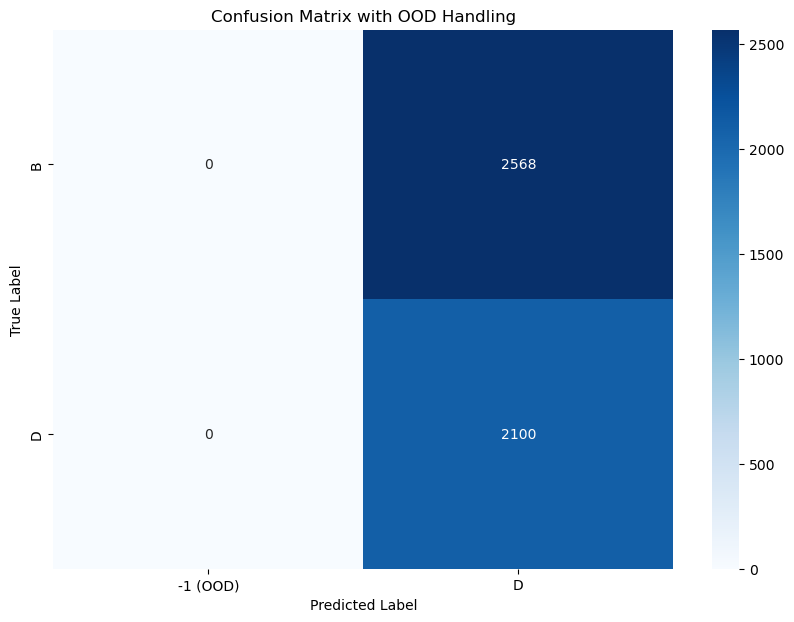

In [28]:
conf_matrix = confusion_matrix(y_test_ood, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels= ['-1 (OOD)',  'D', ], 
            yticklabels= ['B',  'D'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix with OOD Handling')
plt.show()

In [29]:
print(classification_report(y_test_ood, predicted_classes))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      2568
           1       0.45      1.00      0.62      2100

    accuracy                           0.45      4668
   macro avg       0.22      0.50      0.31      4668
weighted avg       0.20      0.45      0.28      4668



c:\Users\miria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\miria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\miria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
